In [1]:
import os
import torch
import wandb
import chess
import chess.pgn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from tqdm import tqdm
from collections import defaultdict

C:\Users\toell\AppData\Local\Temp\ipykernel_28172\3801029896.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
if os.getcwd().split('\\')[-1] != 'irl-chess':
    os.chdir('../')

In [3]:
def win_loss_translation(outcome):
    # positive for white, 2 for checkmate, 1 for resignation
    if outcome[0] == '0':       # White loss
        out = -1
    elif outcome[1] == '-':   # White win
        out = 1
    else:               # Draw
        out = 0
    return out

def parse_pgn(game):
    # CHATGPT (Modified)
    white_elo_start = game.find("WhiteElo") + 10
    white_elo_end = white_elo_start + game[white_elo_start:].find('"')
    white_elo = int(game[white_elo_start:white_elo_end].strip())

    black_elo_start = game.find("BlackElo") + 10
    black_elo_end = black_elo_start + game[black_elo_start:].find('"')
    black_elo = int(game[black_elo_start:black_elo_end].strip())

    moves = []
    game_split =  game.split("\n\n")[1].split(' ')
    for move in game_split:
        if '{' in move:
            break
        if '.' not in move:     # Remove numbering
            moves.append(move)
    outcome = win_loss_translation(game_split[-1])    # Get reason for game ending
    
    game_length = len(moves)
    # (for data), moves
    return (white_elo, black_elo, game_length, outcome), moves

In [4]:
def load_games(path):
    moves_list = []
    data = []
    path_data = path.replace(path.split('/')[-1], 'data.csv')
    path_moves = path.replace(path.split('/')[-1], 'moves.txt')
    try:
        data = pd.read_csv(path_data, sep=',').values
        moves_list = []
        with open(path_moves, 'r') as file:
            for line in file:
                moves_list.append(line.split())
        return moves_list, data
    except FileNotFoundError:
        pass

    with open(path, 'r') as file:
        game = ""
        event_count = 0
        for line in tqdm(file, total=8_936_708, desc='Parsing'):    # Copied from the data file, hard to do dynamically
            game += line
            if 'Event' in line:
                event_count += 1
            if event_count == 2:  # Check if game string is not empty
                (temp), moves = parse_pgn(game)
                moves_list.append(moves)
                data.append(temp)
                game = ""
                event_count = 1
    data = np.array(data)
    pd.DataFrame(data).to_csv(path_data, sep=',')
    with open(path_moves, 'w') as file:
        for move in tqdm(moves_list, desc='Saving Moves'):
            temp_move = ''
            for char in move:
                temp_move += char + ' '
            file.writelines(temp_move[:-1] + '\n')
    return moves_list, data

In [5]:
path = 'data/ficsgamesdb_2021_standard_nomovetimes/ficsgamesdb_2021_standard_nomovetimes.pgn'
moves_list, data = load_games(path)
data_array = np.array(data, dtype=np.int16)

In [6]:
for move in moves_list:
    for temp in move:
        if len(temp) > 7:
            print(temp)

In [7]:
# Print the first 2 games and their corresponding data
for i in range(2):
    print(f"Moves {i + 1}:\n{moves_list[i]}\nWhite Elo: {data[i][0]}, Black Elo: {data[i][1]}, Game Length: {data[i][2]} moves, Outcome: {data[i][3]}\n")

Moves 1:
['Nf3', 'e6', 'e3', 'c5', 'c4', 'Nf6', 'Nd4', 'd5', 'Ne2', 'Bd6', 'cxd5', 'Nxd5', 'Nec3', 'Nxc3', 'dxc3', 'O-O', 'Bb5', 'a6', 'Bd3', 'Nc6', 'O-O', 'Ne5', 'Na3', 'Nxd3', 'Nc2', 'Nxc1', 'Rxc1', 'h6', 'e4', 'Qc7', 'Na3', 'Bxh2+', 'Kh1', 'Bf4', 'Kg1', 'Bxc1', 'Qxc1', 'Qe7', 'Rd1', 'e5', 'f3', 'Be6', 'g3', 'b5', 'f4', 'b4', 'fxe5', 'bxa3', 'bxa3', 'Bg4', 'Qb1', 'Qxe5', 'Kg2', 'Bxd1']
White Elo: 0, Black Elo: 1720, Game Length: 1525 moves, Outcome: 54

Moves 2:
['e4', 'e5', 'Nf3', 'Nc6', 'g3', 'Bc5', 'Bg2', 'd6', 'O-O', 'Bg4', 'c3', 'Nge7', 'd3', 'Qd7', 'Nbd2', 'Bh3', 'Re1', 'g5', 'Nf1', 'f6', 'Qb3', 'O-O-O', 'Be3', 'Na5', 'Qc2', 'Bxe3', 'Nxe3', 'h5', 'b4', 'Nac6', 'a4', 'a5', 'b5', 'Na7', 'c4', 'b6', 'Qc3', 'Kb7', 'Rec1', 'g4', 'Nh4', 'Bxg2', 'Kxg2', 'c5', 'bxc6+', 'Nexc6', 'Nd5', 'Qe6', 'Rab1', 'Nb4', 'Rxb4', 'axb4', 'Qxb4', 'Nc8', 'Rb1', 'Qd7', 'Nxb6', 'Qc6', 'Nd5+', 'Ka7', 'Qb8+', 'Ka6', 'Nc7+', 'Ka5', 'Qb4#']
White Elo: 1, Black Elo: 1920, Game Length: 1518 moves, Outcome: 65


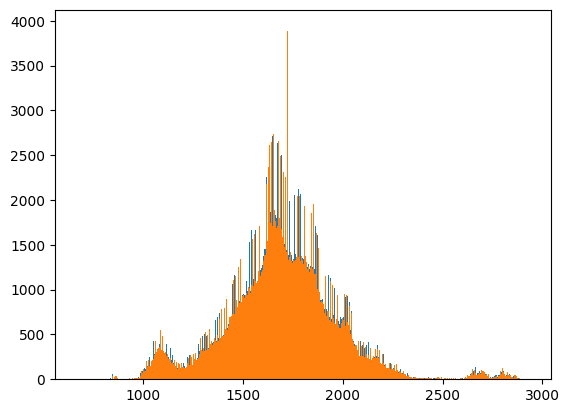

In [8]:
bins = 1000
plt.hist(data_array[:, 1], bins=bins, label='White ELO')
plt.hist(data_array[:, 2], bins=bins, label='Black ELO')
plt.show()

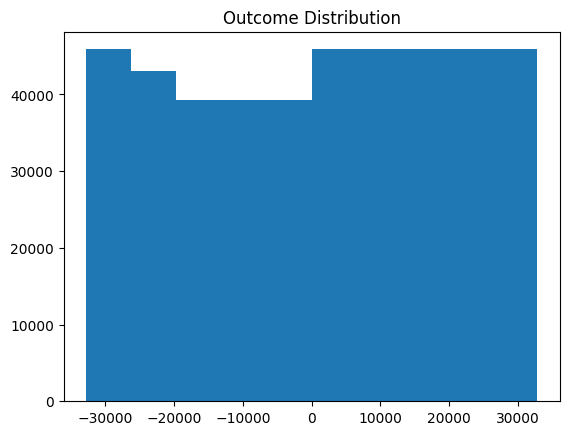

In [9]:
bins = 10
plt.hist(data_array[:, 0], bins=bins, label='Outcome')
plt.title('Outcome Distribution')
plt.show()

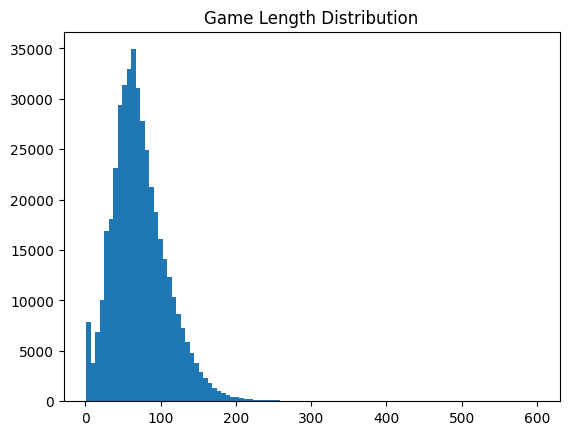

In [10]:
bins = 100
plt.hist(data_array[:, 3], bins=bins, label='Game Length')
plt.title('Game Length Distribution')
plt.show()

In [30]:
def get_board_arrays(game_moves):
    board = chess.Board()
    positions = []

    for move in game_moves:
        board.push_san(move)
        positions.append(board_to_array(board))

    return positions

def board_to_array(board, material_dict=None, tensor=False):
    if material_dict is None:
        material_dict = {i: i for i in range(1, 7)}
    arr = np.zeros(64, dtype=np.int8)
    for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece is not None:
                arr[square] = material_dict[piece.piece_type] * (1 if piece.color else -1)
    # arr = arr.reshape((8, 8))     # Need a reason to reshape
    return arr if not tensor else torch.tensor(arr)

In [12]:
positions = get_board_arrays(moves_list[1000])

for position in positions:
    print(position)

[ 4  2  3  5  6  3  2  4  1  1  1  1  0  1  1  1  0  0  0  0  0  0  0  0
  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 -1 -1 -1 -1 -1 -1 -1 -1 -4 -2 -3 -5 -6 -3 -2 -4]
[ 4  2  3  5  6  3  2  4  1  1  1  1  0  1  1  1  0  0  0  0  0  0  0  0
  0  0  0  0  1  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0
 -1 -1  0 -1 -1 -1 -1 -1 -4 -2 -3 -5 -6 -3 -2 -4]
[ 4  2  3  5  6  3  0  4  1  1  1  1  0  1  1  1  0  0  0  0  0  2  0  0
  0  0  0  0  1  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0
 -1 -1  0 -1 -1 -1 -1 -1 -4 -2 -3 -5 -6 -3 -2 -4]
[ 4  2  3  5  6  3  0  4  1  1  1  1  0  1  1  1  0  0  0  0  0  2  0  0
  0  0  0  0  1  0  0  0  0  0 -1  0  0  0  0  0  0  0 -2  0  0  0  0  0
 -1 -1  0 -1 -1 -1 -1 -1 -4  0 -3 -5 -6 -3 -2 -4]
[ 4  2  3  5  6  3  0  4  1  1  1  0  0  1  1  1  0  0  0  0  0  2  0  0
  0  0  0  1  1  0  0  0  0  0 -1  0  0  0  0  0  0  0 -2  0  0  0  0  0
 -1 -1  0 -1 -1 -1 -1 -1 -4  0 -3 -5 -6 -3 -2 -4]
[ 4  2  3  5  6  3  

In [13]:
def depth_first_search(starting_board: chess.Board, 
                       true_move: str,
                       weights: torch.Tensor=torch.ones(1), 
                       depth: int=2, 
                       heuristic_function=None):
    if heuristic_function is None:
        def heuristic_function(board: chess.Board):
            return torch.ones_like(weights)
    # depth refers to depth of moves by moving player
    boards_seen = [[starting_board]] + [[] for _ in range(depth*2)]
    boards_not_seen = [[starting_board]] + [[] for _ in range(depth*2)]
    
    for i in tqdm(range(depth*2)):
        for board in boards_not_seen[i]:
            for move in board.legal_moves:
                board_ = deepcopy(board)
                san_move = board_.san(move)
                board_.push(move)
                if san_move != true_move:
                    boards_not_seen[i + 1].append(board_)
        for board in boards_seen[i]:
            for move in board.legal_moves:
                board_ = deepcopy(board)
                _ = board_.push(move)
                boards_seen[i + 1].append(board_)
        
    return boards_not_seen, boards_seen   
    
def set_board(moves: list[str]):
    board = chess.Board()
    for move in moves:
        board.push_san(move)
    return board



In [63]:
def calculate_heuristics(board: chess.Board, tensor=False):
    material_dict = {
        chess.PAWN: 1,
        chess.KNIGHT: 3,
        chess.BISHOP: 3,
        chess.ROOK: 5,
        chess.QUEEN: 9,
        chess.KING: 0  # The value for the king is typically set to 0 in material evaluation
    }
    board_arr = board_to_array(board, material_dict=material_dict, tensor=tensor)
    
    # material_white = np.sum(board_arr[board_arr > 0])
    # material_black = np.abs(np.sum(board_arr[board_arr < 0]))
    pieces_white = [np.sum(board_arr == i) if not tensor else torch.sum(board_arr == i) for i in range(1, 6)]
    pieces_black = [np.sum(board_arr == i) if not tensor else torch.sum(board_arr == i) for i in range(-5, 0)]
    check = board.is_check()
    checkmate = board.is_checkmate()
    out = (*pieces_white, *pieces_black, check, checkmate)
    return torch.tensor(out, dtype=torch.float) if tensor else np.array(out, dtype=float)

def evaluate(board: chess.Board, R):
    return calculate_heuristics(board, tensor=True) @ R

def alpha_beta_search(board, depth, alpha=-torch.inf, beta=torch.inf, maximize=True, R: torch.Tensor=torch.zeros(1)):
    if depth == 0 or board.is_game_over():
        return evaluate(board, R)

    if maximize:
        max_eval = -torch.inf
        for move in board.legal_moves:
            board.push(move)
            eval = alpha_beta_search(board, depth - 1, alpha, beta, False, R=R)
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break  # Beta cut-off
        return max_eval
    else:
        min_eval = torch.inf
        for move in board.legal_moves:
            board.push(move)
            eval = alpha_beta_search(board, depth - 1, alpha, beta, True, R=R)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break  # Alpha cut-off
        return min_eval

# Example usage with a chess-like board
import chess

def get_best_move(board, R, depth=3):
    best_move, Q = None, None
    alpha = -torch.inf
    
    for move in board.legal_moves:
        board.push(move)
        Q = alpha_beta_search(board, alpha=alpha, depth=depth, maximize=True, R=R)
        board.pop()
        if Q > alpha:
            alpha = Q
            best_move = move
    return best_move, Q

print(f"The best move is: {get_best_move(chess.Board(), R=torch.rand(12))}")

The best move is: (Move.from_uci('g1h3'), tensor(21.8367))


In [14]:
b = set_board(moves_list[0][:5])
print(calculate_heuristics(b))
positions_seen, positions_not_seen = depth_first_search(b, true_move=moves_list[0][5], depth=1)

(8, 0, 4, 0, 2, 2, 0, 4, 0, 8, False, False)


100%|██████████| 2/2 [00:00<00:00, 29.83it/s]


In [15]:
X = torch.tensor(np.array([calculate_heuristics(board) for board in positions_seen[-1] + positions_not_seen[-1]], dtype=float), requires_grad=True, dtype=torch.float)
y = torch.tensor([1.] * len(positions_seen[-1]) + [0.] * len(positions_not_seen[-1]), requires_grad=True, dtype=torch.float)

In [18]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import MeanSquaredError
import pytorch_lightning as pl
import wandb

class SimpleRegressionModel(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRegressionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, output_size)
        )
        self.loss_function = nn.MSELoss()
        self.mse = MeanSquaredError()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        predictions = self(x)
        loss = self.loss_function(predictions.squeeze(), y.squeeze())
        self.log('train_loss', loss.item(), on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.squeeze()
        predictions = self(x).squeeze()
        loss = self.loss_function(predictions, y)
        self.log('val_loss', loss.item(), on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

# Example usage
input_size = X.shape[-1]
hidden_size = 64
output_size = 1

# Create DataLoader
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Initialize the model
model = SimpleRegressionModel(input_size, hidden_size, output_size)

# Initialize PyTorch Lightning Trainer
wandb_logger = pl.loggers.WandbLogger(project="irl-chess-init", log_model="all")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(
    max_epochs=10,         
    precision="32-true",
    logger=wandb_logger,
    log_every_n_steps=45
)
# Train the model
trainer.fit(model, train_dataloaders=loader, val_dataloaders=loader)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 13    
1 | loss_function | MSELoss          | 0     
2 | mse           | MeanSquaredError | 0     
---------------------------------------------------
13        Trainable params
0         Non-trainable params
13        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


epoch,▁▂▂▃▃▄▄▅▆▆▆▇█▁▁▂▃▃▃▄▅▆▆▆▇██▁▂▃▃▃▄▅▅▆▆▇▇█
train_loss_epoch,▇▃▂▂▂▂▂▂▃▃▁▃▃▃▃▃▃▃▃▃█▃▂▂▂▂▂▂▂▃
train_loss_step,█▆▅▃▆▆▅▃▂▁▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂
trainer/global_step,▁▁▂▃▃▄▄▅▆▆▆▇█▁▁▂▃▃▃▄▅▆▆▆▇██▁▂▃▃▃▄▅▅▆▆▇▇█
val_loss,▆▁▂▂▂▂▂▂▂▂█▃▃▃▃▃▃▃▃▃▇▁▂▂▂▂▂▂▂▂
epoch,9
train_loss_epoch,0.33618
train_loss_step,0.14317
trainer/global_step,449
val_loss,0.26769


In [19]:
torch.cuda.is_available()

True

In [16]:
def training_procedure(theta: torch.Tensor, transition_pairs: list[tuple[chess.Board, chess.Board]], epsilon: float, epochs: int):
    
    for i in tqdm(range(epochs)):
        policy = approx_value_iteration(theta, transition_pairs, epsilon)

def approx_value_iteration(R: torch.Tensor, transition_pairs: list[tuple[chess.Board, chess.Board]], epsilon: float):
    V = defaultdict(lambda: -torch.inf)
    V_t = V
    Q = defaultdict(lambda: 0)
    while dict_diff(V, V_t) > epsilon:
        for state, state_t in transition_pairs:
            for move in state.legal_moves:
                Q[(state, move)] = get_Q(state, state_t, move)


def dict_diff(dict1, dict2):
    out = torch.inf
    for key, value in dict1.items():
        if value != -torch.inf and dict2[key] != -torch.inf:
            out = max(abs(value - dict2[key]), (0 if out != torch.inf else out))
    return out

def get_Q(state: chess.Board, state_t: chess.Board, move: chess.Move, R, V):
    Q = R @ torch.tensor(calculate_heuristics(state)).T + V[state_t]
    return Q

In [118]:
def prob_dist(R, energy, alpha, prior=lambda R: 1):
    prob = torch.exp(alpha * energy) * prior(R)
    return prob

def policy_walk(R, states, moves, delta=1e-3, epochs=10, depth=3, alpha=2e-2):
    for epoch in tqdm(range(epochs)):
        add = torch.randn_like(R) * (delta / 2)
        R_ = R + add
        Q_moves = torch.zeros(len(states))
        Q_policy = torch.zeros(len(states))
        i = 0
        energy_new, energy_old = 0, 0
        for state, move in tqdm(zip(states, moves), total=len(states)):
            state.push_san(move)
            _, Q_old = get_best_move(board=state, R=R, depth=depth-1)
            state.pop()
            _, Q_new = get_best_move(board=state, R=R_, depth=depth)
            _, Q_old_energy = get_best_move(board=state, R=R, depth=depth)
            
            Q_moves[i] = Q_old
            Q_policy[i] = Q_new
            
            energy_new += Q_new
            energy_old += Q_old_energy

            i += 1
            prob = min(1, prob_dist(R_, energy_new, alpha=alpha)/prob_dist(R_, energy_old, alpha=alpha))
            if torch.sum(Q_policy < Q_moves):
                if torch.rand(1).item() < prob:
                    R = R_
    return R

In [100]:
steps = 5
elo_range = (1000, 1050)
boards, next_moves = [], []
for moves, data_ in tqdm(zip(moves_list, data), total=len(data)):
    if sum(elo_range[0] > data_[1:3]) + sum(data_[1:3] > elo_range[1]):
        continue
    
    board = chess.Board()
    if len(moves) > steps + 1:
        for move in moves[:steps]:
            board.push_san(move)
        boards.append(board)
        next_moves.append(moves[steps])

100%|██████████| 436287/436287 [00:04<00:00, 102838.47it/s]


In [119]:
theta = torch.rand(12)
theta_star = policy_walk(theta, boards, next_moves, epochs=2, depth=1)
print(theta - theta_star)

100%|██████████| 2/2 [00:59<00:00, 29.65s/it]

tensor([ 3.2020e-04,  4.3811e-04,  7.8923e-04, -2.2137e-04,  1.1146e-05,
         1.9333e-04,  2.5988e-05, -5.9187e-05,  9.8510e-04,  1.8460e-04,
         1.3393e-03,  2.1666e-04])
